In [1]:
import cbpro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import arrow
from requests.auth import AuthBase
import plotly.graph_objs as go


pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000


In [2]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff

# Read CSV File

In [3]:
#new_df.to_csv('ETHUSD5M.csv',index=False)

In [9]:
test = pd.read_csv('BTCDaily.csv')

test.shape

(1842, 6)

In [11]:
#test.drop('Unnamed: 0',axis=1,inplace=True)
test = test.sort_values('Date')

In [12]:
test['avg'] = (test[['Low','High','Close']].sum(axis=1))/3

In [13]:
#test = test.set_index('Date')
test = test[['Date','Open','High','Low','Close','Volume','avg']].copy()
test.columns = ['Date','Open','High','Low','Close','Volume','avg']

In [15]:
test['Date'] = pd.to_datetime(test['Date'])

In [16]:
test = test.set_index('Date',drop=True)
test.head(5)

,Open,High,Low,Close,Volume,avg
Date,,,,,,
2016-01-11,449.99,452.65,445.88,449.19,5597.637183,449.240000
2016-01-12,449.26,449.44,431.83,434.01,6596.945453,438.426667
2016-01-13,434.01,437.50,425.00,432.77,9009.150709,431.756667
2016-01-14,432.70,435.27,428.00,430.03,5673.632962,431.100000
2016-01-15,430.04,430.29,357.30,357.53,28641.673586,381.706667


In [17]:
#Create my technical analysis indicators which are going to be my features

x = ['Close','Volume','avg']
t1 = 7
t2 = 14
for i in test[x]:

    c1 = 'rtn_' + i
    c2 = 'abs_rtn_' + i
    test[c1] = np.log(test[i]/test[i].shift(1))
    test[c2] = abs(np.log(test[i]/test[i].shift(1)))
    c3 = i + '_std' + str(t1)
    c4 = i + '_std' + str(t2) 
    test[c3] = test[i].rolling(window=t1).std()
    test[c4] = test[i].rolling(window=t2).std()
    
    c5 = c2 + '_' + str(t1) + 'MA'
    c6 = c2 + '_' + str(t2) + 'MA'
    test[c5] = test[c2].rolling(window=t1).mean()
    test[c6] = test[c2].rolling(window=t2).mean()
    c7 = i + '_' + str(t1) + 'EMA'
    c8 = i + '_' + str(t2) + 'EMA'
    test[c7] = test[i].ewm(span=t1,adjust=True).mean()
    test[c8] = test[i].ewm(span=t2,adjust=True).mean()
    c9 = i + '_' + str(t1) + 'MA'
    c10 = i + '_' + str(t2) + 'MA'
    test[c9] = test[i].rolling(window=t1).mean()
    test[c10] = test[i].rolling(window=t2).mean()
    
   
    c11 = 'Diff_' + c8 + c7
    test[c11] = test[c8] - test[c7]
        #Bollinger on Close price
    if i == 'Close' or 'avg':
        
        bol1 = ['BolUp'+c9,'BolDn'+c9]
        bol2 = ['BolUp'+c10,'BolDn'+c10]

        test[bol1[0]] = test[i].rolling(window=t1).mean() + (test[c2]*2.5) 
        test[bol1[1]] = test[i].rolling(window=t1).mean() - (test[c2]*2.5)
        test[bol2[0]] = test[i].rolling(window=t2).mean() + (test[c3]*2.5)
        test[bol2[1]] = test[i].rolling(window=t2).mean() - (test[c3]*2.5) 


In [18]:
#Create the RSI, Relative Strength Indicator 

rsi_period = 14
rsi = pd.DataFrame(test['Close'],index=test.index)
rsi['rtn'] = rsi['Close'].diff(periods=1)
rsi['po_rtn'] = [x if x > 0 else 0 for x in rsi['rtn']]
rsi['neg_rtn'] = [x if x < 0 else 0 for x in rsi['rtn']]
#rsi = rsi.iloc[1:,:]
rsi['RS'] = rsi['po_rtn'].ewm(span=rsi_period).mean()/rsi['neg_rtn'].abs().ewm(span=rsi_period).mean()
rsi['rsi'] = 100-(100/(1+rsi['RS']))

In [19]:
test['RSI_Close'] = rsi['rsi']

In [21]:
#Volume indicator
test['Volume_ratio'] = test['Volume'] / test['Volume_7MA']

#Features to locate the price divergence from the bollinger bands
test['Close_MAs_ratio'] = test['Close_14MA'] / test['Close_7MA']
test['DnBol_Dist_14'] = test['Close'] - test['BolDnClose_14MA']
test['UpBol_Dist_14'] = test['Close'] - test['BolUpClose_14MA']
test['Dist_BolDn_BolUp'] = test['BolUpClose_14MA'] - test['BolDnClose_14MA']

In [22]:
#Average true range calculation, volatility indicator

t3 = 14  #the standard period for daily chart
ATR = pd.DataFrame()
ATR['HighLow'] = test['High'] - test['Low']
ATR['High_Close-1'] = abs(test['High'] - test['Close'].shift(-1))
ATR['Low_Close-1'] = abs(test['Low'] - test['Close'].shift(-1))
ATR['True_Range'] = ATR.max(axis=1)
ATR['ATR'] = ATR['True_Range'].rolling(window=t3).mean()

In [23]:
test['ATR'] = ATR['ATR']

In [26]:
#test = pd.read_csv('data-eth-15min.csv')
#test = test.set_index(pd.to_datetime(test['Date']))

In [27]:
support = pd.DataFrame(test['Close'])
support.head()

,Close
Date,
2016-01-11,449.19
2016-01-12,434.01
2016-01-13,432.77
2016-01-14,430.03
2016-01-15,357.53


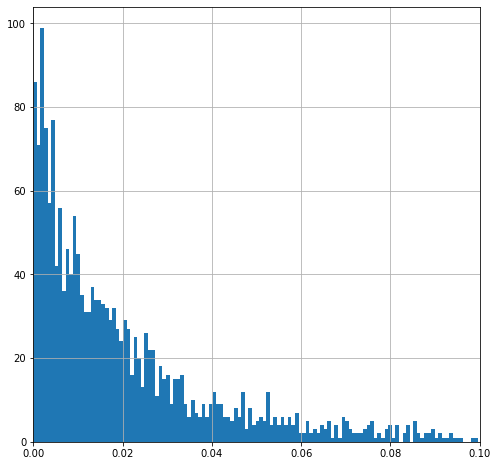

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
test['abs_rtn_avg'].hist(bins=500)
plt.xlim(0,0.1)
plt.show()

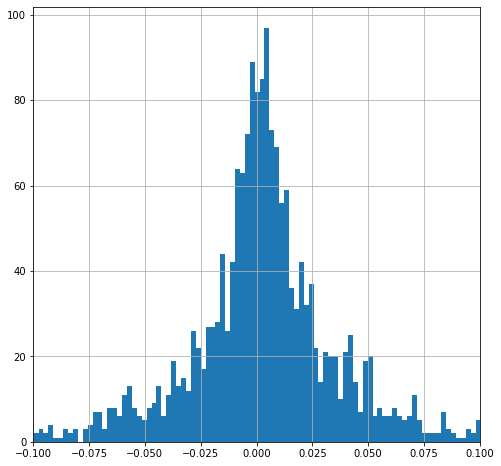

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
test['Close'].pct_change(periods=1).hist(bins=300)
plt.xlim(-0.10,0.10)
plt.show()

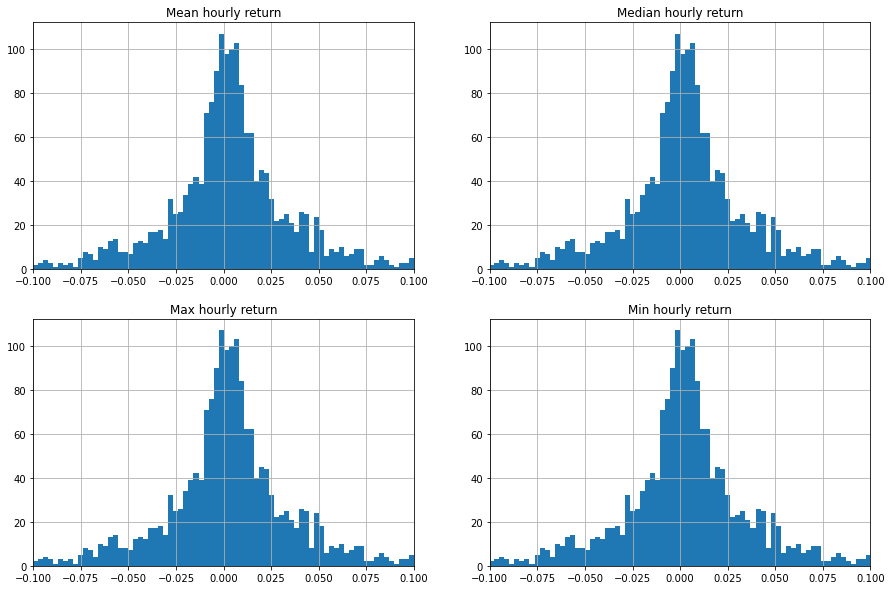

In [35]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
test.resample('D').mean()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[0,0])
test.resample('D').median()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[0,1])
test.resample('D').max()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[1,0])
test.resample('D').min()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[1,1])
ax[0,0].set_title('Mean hourly return')
ax[0,1].set_title('Median hourly return')
ax[1,0].set_title('Max hourly return')
ax[1,1].set_title('Min hourly return')
ax[0,0].set_xlim(-0.10,0.10)
ax[0,1].set_xlim(-0.10,0.10)
ax[1,0].set_xlim(-0.10,0.10)
ax[1,1].set_xlim(-0.10,0.10)
plt.show()

In [36]:
#Create my target variable: 
# return for the next 30min (15min data),
# return for the next 4h (hourly data), 
# return the next 2d (daily data),
# Then make a column that says if the return is positive or negative (flat return included) .
test['Return_4d'] = test['Close'].pct_change(4).shift(-5)

In [38]:
test[['Close','Return_4d']].head(5)

,Close,Return_4d
Date,,
2016-01-11,449.19,-0.104399
2016-01-12,434.01,-0.125494
2016-01-13,432.77,-0.104969
2016-01-14,430.03,0.049618
2016-01-15,357.53,0.076769
2016-01-16,388.70,0.081700
2016-01-17,378.46,-0.005170
2016-01-18,384.89,0.032590
2016-01-19,375.27,-0.037010


In [193]:
test['Return_4d'].describe()

count    1837.000000
mean        0.012741
std         0.080368
min        -0.395715
25%        -0.024452
50%         0.008620
75%         0.051109
max         0.540302
Name: Return_4d, dtype: float64

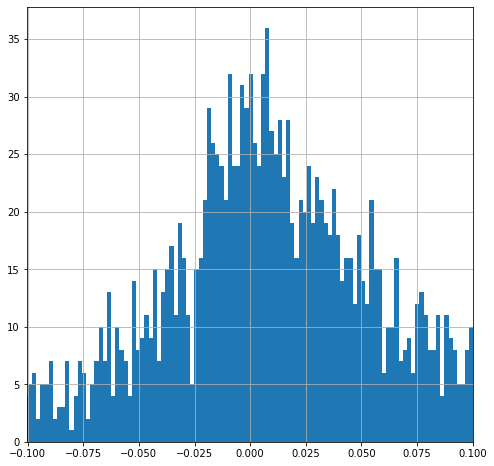

In [194]:
fig, ax = plt.subplots(figsize=(8,8))
test['Return_4d'].hist(bins=500)
plt.xlim(-0.1003,0.1003)
plt.show()

In [195]:
test[test['Return_4d'] == 0.000000].loc[:,'Return_4d']

Date
2016-08-08 01:00:00    0.0
Name: Return_4d, dtype: float64

In [196]:
test['BuyorSell'] = [-1 if x <= 0 else 1 for x in test['Return_4d']]

In [197]:
# I am including the flat return to the positive return target variable in the model notebook.
test['BuyorSell'].value_counts(normalize=True)

 1    0.571661
-1    0.428339
Name: BuyorSell, dtype: float64

In [198]:
#Saving the finale data
test.to_csv('data-btc-daily.csv')